### Tripadvisor Hotel Reviews  dataset
#### - load the dataset and explore it 
#### - create features out of text with Bag of Words method
#### - train a model
#### - evaluate the model
#### - tune the BoW parameters and repeat the training and evaluation steps
#### - use stopwords to improve the performance

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
%matplotlib inline

### Load dataset

In [3]:
# Add the space character ' ' into the existing list of characters that are intrepreted as missing values
# Because there may be no text in the Review column
missing_values_string = [' ', '', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND',
                         '1.#QNAN', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null']

In [5]:
data = pd.DataFrame(pd.read_csv('../data/tripadvisor_hotel_reviews.csv', na_values=missing_values_string))
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


### Explore the data

In [6]:
data.tail()

,Review,Rating
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1
20490,"people talking, ca n't believe excellent ratin...",2


In [7]:
data.Review[2]

"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 6

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [9]:
# Check if all ratings are in the range[0,5]
assert data.Rating.max() <= 5
assert data.Rating.min() >= 1

# Check if there are missing values
print(" Column Name \t Num of Missing values\n",'-'*40)
print(data.isna().sum())

 Column Name 	 Num of Missing values
 ----------------------------------------
Review    0
Rating    0
dtype: int64


In [10]:
data['Label'] = [1 if i>=4 else 0 for i in data.Rating.values]

In [11]:
data.head()

,Review,Rating,Label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


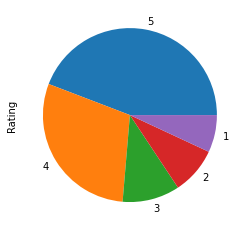

In [12]:
data.Rating.value_counts().plot(kind='pie');

In [13]:
data.Label.value_counts()

1    15093
0     5398
Name: Label, dtype: int64

<AxesSubplot:ylabel='Label'>

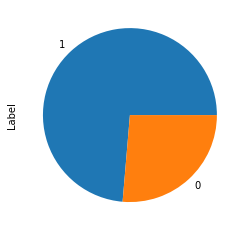

In [14]:
data.Label.value_counts().plot(kind='pie')

The dataset is imbalanced !

How many instances are there from the minority class?

In [15]:
len(data[data.Label==0])

5398

### Detect if there are duplicate reviews

In [16]:
# Get duplicates across all columns
duplicates = data.duplicated(subset='Review')  
all_duplicates = data[duplicates == True]

# Number of duplicates
total_duplicates = len(all_duplicates)
print("Number of total duplicates is : ", total_duplicates)

Number of total duplicates is :  0


### Remove special characters from reviews and convert to lower case

In [17]:
data.Review = data.Review.apply(lambda x: x.lower()) #lower cases
data.Review = data.Review.apply((lambda x: re.sub('[^a-zA-Z0-9\s]','',x))) 

In [18]:
data.Review[2]

'nice rooms not 4 experience hotel monaco seattle good hotel nt 4 levelpositives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized missed 3 separate wakeup calls concierge busy hard touch did nt provide guidance special requeststv hard use ipod sound dock suite non functioning decided book mediterranean suite 3 night weekend stay 1st choice rest party filled comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice showerbefore stay hotel arrange car service price 53 tip reasonable driver waiting arrivalcheckin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did nt stay night got 121a checked voucher bottle champagne nice gesture fish waiting room impression room huge open space felt room big tv far away bed chore change channel ipod dock broken disappointingin morning way asked desk check thermostat said 65f 74 2 degrees warm

### Add a column for the length of the reviews

In [19]:
data['Length'] = data.Review.apply(lambda x: len(x.split(' ')))   
data.head()

,Review,Rating,Label,Length
0,nice hotel expensive parking got good deal sta...,4,1,89
1,ok nothing special charge diamond member hilto...,2,0,252
2,nice rooms not 4 experience hotel monaco seatt...,3,0,219
3,unique great stay wonderful time hotel monaco ...,5,1,91
4,great stay great stay went seahawk game awesom...,5,1,193


### Analyze about length attribute

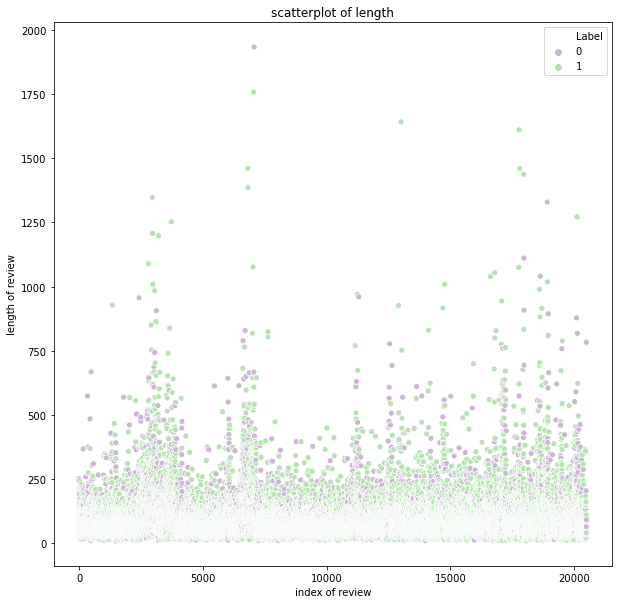

In [20]:
plt.figure(figsize=(10,10))
sns.scatterplot( x = data.Length.index, y = data.Length, hue = data.Label, data=data, palette='PRGn')
plt.ylabel("length of review")
plt.xlabel("index of review")
plt.title("scatterplot of length")
plt.show()

Here we can detect a few outliers in terms of review length

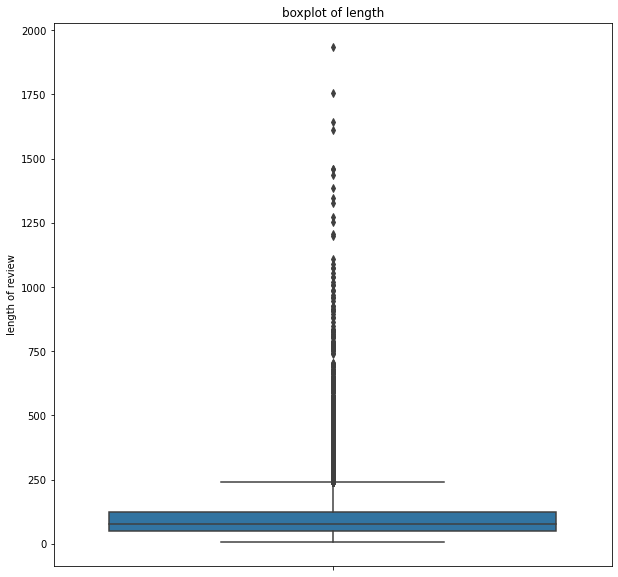

In [21]:
plt.figure(figsize=(10,10))
sns.boxplot(y = data.Length, data=data)
plt.ylabel("length of review")
plt.title("boxplot of length")
plt.show()

Negative mean length: 120.04
Positive mean length: 101.49
Mean Difference: 18.55
Max length of Negative class: 1933.00
Max length of Positive class: 1757.00
Min length of Negative class: 11.00
Min length of Positive class: 9.00


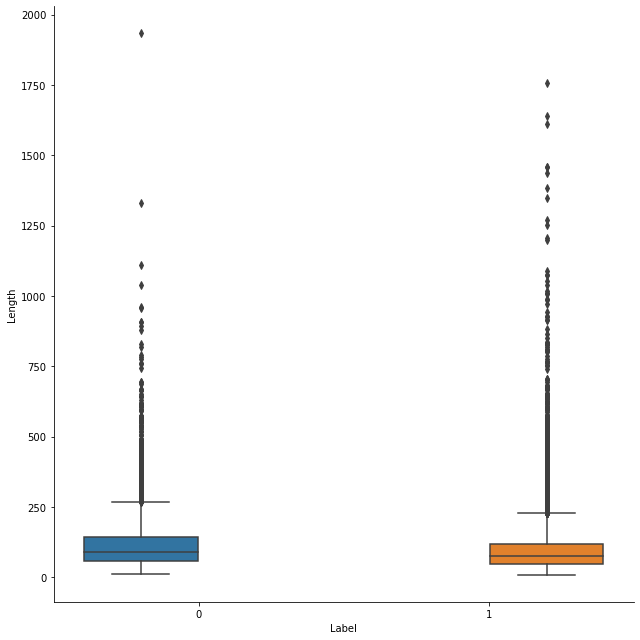

In [22]:
neg_mean_len = data.groupby('Label')['Length'].mean().values[0]
pos_mean_len = data.groupby('Label')['Length'].mean().values[1]

max_neg_len = data[data.Label==0].Length.max()
max_pos_len = data[data.Label==1].Length.max()

min_neg_len = data[data.Label==0].Length.min()
min_pos_len = data[data.Label==1].Length.min()

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")

print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")

print(f"Max length of Negative class: {max_neg_len:.2f}")
print(f"Max length of Positive class: {max_pos_len:.2f}")

print(f"Min length of Negative class: {min_neg_len:.2f}")
print(f"Min length of Positive class: {min_pos_len:.2f}")

#Plot the length boxplot
sns.catplot(x='Label', y='Length',hue='Label', data=data, kind='box', height=9, aspect=1);

# Training

In [23]:
#Set the features and the target
text = data.Review
label = data.Label

In [24]:
#Split into train and test set
text_train, text_test, y_train, y_test = train_test_split(text, label, test_size=0.25, random_state=0, shuffle=True, stratify=label)

### Create features from the text data

In [25]:
#Convert a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer()

##### Let's see a simple example first

In [26]:
corpus = ['This is the first document.', 
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?' ]

In [27]:
#Retrieve the terms found in the corpus
vectorized_corpus = vectorizer.fit_transform(corpus)
tokens = vectorizer.get_feature_names()
df_vect = pd.DataFrame(data = vectorized_corpus.toarray(), index = ['Doc1','Doc1','Doc3','Doc4'], columns = tokens)
df_vect

,and,document,first,is,one,second,the,third,this
Doc1,0,1,1,1,0,0,1,0,1
Doc1,0,2,0,1,0,1,1,0,1
Doc3,1,0,0,1,1,0,1,1,1
Doc4,0,1,1,1,0,0,1,0,1


In [28]:
#Vocabulary derived from the corpus
vectorizer.vocabulary_

{'this': 8,
 'is': 3,
 'the': 6,
 'first': 2,
 'document': 1,
 'second': 5,
 'and': 0,
 'third': 7,
 'one': 4}

In [29]:
#Vocabulary size
len(vectorizer.vocabulary_)

9

##### We can try to reconstruct the original corpus but it may differ fro the original 

In [30]:
restored_corpus = vectorizer.inverse_transform(vectorized_corpus)
restored_corpus

[array(['this', 'is', 'the', 'first', 'document'], dtype='<U8'),
 array(['this', 'is', 'the', 'document', 'second'], dtype='<U8'),
 array(['this', 'is', 'the', 'and', 'third', 'one'], dtype='<U8'),
 array(['this', 'is', 'the', 'first', 'document'], dtype='<U8')]

# Now let's vectorize our data

In [31]:
#Fit and Transform the train text, then transform the test text
text_train_vect = vectorizer.fit_transform(text_train)
text_test_vect = vectorizer.transform(text_test)

What is the practical meaning of the above ?

In [32]:
#Create a dataframe of the new representation
tokens = vectorizer.get_feature_names()
df_vect = pd.DataFrame(data = text_train_vect.toarray(), columns = tokens)
display(df_vect)

,00,000,0001,000rp,0030,005,01,0102where,0114,012305012905,...,zorbas,zucca,zuid,zum,zumo,zurich,zvago,zyrtec,zytec,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Can you detect how many features do we have now?

Do they all make sense? If not, should we drop them? Why?

### Train the model 

In [33]:
#Define the training model -> We are going to use RandomForest
RF = RandomForestClassifier(n_estimators=100, random_state=0) #try different values for max_depth, max_features

#Fit the model on training data
RF_model = RF.fit(text_train_vect, y_train)

In [34]:
#Make the model's predictions for the test data
y_test_pred = RF.predict(text_test_vect)

#### Extract the feature importances according to the trained model

In [35]:
RF.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.35624233e-06, 0.00000000e+00, 1.22768485e-07])

#### Use a visualization to better understand the feature importances

In [36]:
feature_importance_list = sorted(zip(RF.feature_importances_, tokens), reverse=True)

In [37]:
#See the top 10 features
feature_importance_list[:10]

[(0.013961353051627575, 'not'),
 (0.011177689891221983, 'great'),
 (0.006914169813856097, 'dirty'),
 (0.006655163708902772, 'told'),
 (0.006476068775953199, 'worst'),
 (0.006083632259920673, 'no'),
 (0.005629505749992252, 'ok'),
 (0.004443828300475579, 'excellent'),
 (0.004205985945276056, 'terrible'),
 (0.0041131285675052795, 'wonderful')]

In [38]:
#See the worst 10 features
feature_importance_list[-10:]

[(0.0, '0200'),
 (0.0, '02'),
 (0.0, '012305012905'),
 (0.0, '0114'),
 (0.0, '0102where'),
 (0.0, '01'),
 (0.0, '005'),
 (0.0, '0001'),
 (0.0, '000'),
 (0.0, '00')]

In [39]:
#We will create a series to visualize whichever feature we want
feature_imp = pd.Series(RF.feature_importances_, index = tokens).sort_values(ascending=False)

top_feature = feature_imp.take([0,1,2,3,4,5,6,7,8,9,10])
worst_features = feature_imp.take([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1])

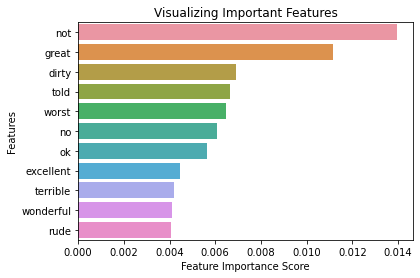

In [40]:
sns.barplot(x=top_feature, y=top_feature.index )

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

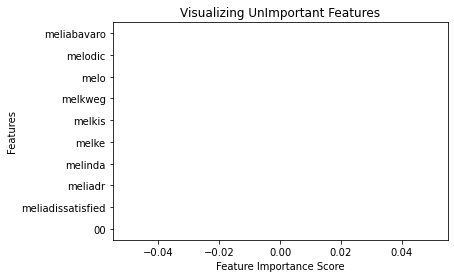

In [41]:
sns.barplot(x=worst_features, y=worst_features.index )

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing UnImportant Features")
plt.show()

### Calculate model's performance

In [42]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.40      0.56      1350
           1       0.82      0.99      0.90      3773

    accuracy                           0.84      5123
   macro avg       0.89      0.70      0.73      5123
weighted avg       0.86      0.84      0.81      5123



<function matplotlib.pyplot.show(close=None, block=None)>

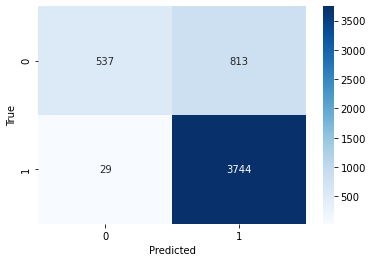

In [43]:
#create the confusion matrix
cf_matrix = confusion_matrix(y_test, y_test_pred)

#plot the confusion matrix
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show

### Let's tune the CountVectorizer parameters to create a different feature set

In [44]:
vectorizer2 = CountVectorizer(lowercase=True, max_df=0.9, min_df=100, max_features=35000)

In [45]:
len(data.Label[data.Label==0])

5398

In [46]:
len(data)

20491

In [47]:
len(data)*0.9

18441.9

In [48]:
text_train_vect2 = vectorizer2.fit_transform(text_train)
text_test_vect2 = vectorizer2.transform(text_test)
tokens2 = vectorizer2.get_feature_names()
df_vect2 = pd.DataFrame(data = text_train_vect2.toarray(),columns = tokens2)
display(df_vect2)

,10,100,1000,11,12,13,14,15,150,16,...,writing,written,wrong,yards,year,years,yes,yogurt,york,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15363,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
15364,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
15365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15366,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Let us check that words with similar meaning have smaller cosine similarities

In [68]:
from sklearn.metrics.pairwise import cosine_similarity

In [69]:
cosine_similarity(df_vect2["writing"].values.reshape(1, -1), df_vect2["written"].values.reshape(1, -1))

array([[0.02809111]])

In [72]:
cosine_similarity(df_vect2["writing"].values.reshape(1, -1), df_vect2["year"].values.reshape(1, -1))

array([[0.0691101]])

In [75]:
cosine_similarity(np.array([[1, 1, 1]]), np.array([[1,1,1]]))

array([[1.]])

In [48]:
#Define the training model
RF2 = RandomForestClassifier(n_estimators=100, random_state=0) #try different values for max_depth

#Fit the model on training data
RF_model = RF2.fit(text_train_vect2, y_train)

In [49]:
#Make the model's predictions for the test data
y_test_pred2 = RF2.predict(text_test_vect2)

In [50]:
feature_importance_list2 = sorted(zip(RF2.feature_importances_, tokens2), reverse=True)

In [51]:
feature_imp2 = pd.Series(RF2.feature_importances_, index = tokens2).sort_values(ascending=False)

top_feature2 = feature_imp2.take([0,1,2,3,4,5,6,7,8,9,10])
worst_features2 = feature_imp2.take([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1])

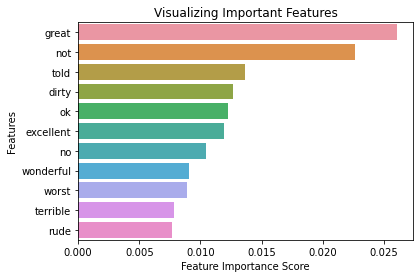

In [52]:
sns.barplot(x=top_feature2, y=top_feature2.index )

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

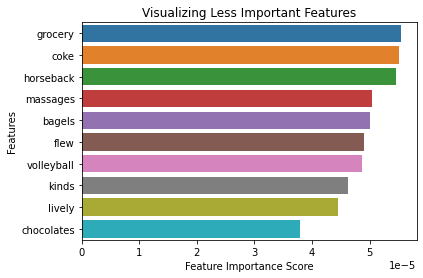

In [53]:
sns.barplot(x=worst_features2, y=worst_features2.index )

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Less Important Features")
plt.show()

In [54]:
print(classification_report(y_test, y_test_pred2))

              precision    recall  f1-score   support

           0       0.90      0.54      0.67      1350
           1       0.86      0.98      0.91      3773

    accuracy                           0.86      5123
   macro avg       0.88      0.76      0.79      5123
weighted avg       0.87      0.86      0.85      5123



<function matplotlib.pyplot.show(*args, **kw)>

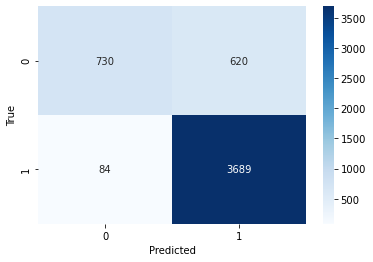

In [55]:
#create the confusion matrix
cf_matrix = confusion_matrix(y_test, y_test_pred2)

#plot the confusion matrix
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show

In [56]:
vectorizer2.vocabulary_

{'highly': 800,
 'recommended': 1363,
 'thoroughly': 1713,
 'enjoyed': 567,
 'stay': 1613,
 'low': 980,
 'key': 895,
 'luxury': 988,
 'special': 1577,
 'touches': 1741,
 'attentive': 131,
 'friendly': 694,
 'staff': 1595,
 'room': 1429,
 'service': 1491,
 'breakfast': 236,
 'hang': 768,
 'phone': 1223,
 'minutes': 1062,
 'walk': 1850,
 'major': 1000,
 'museums': 1083,
 'price': 1287,
 'good': 737,
 'deal': 455,
 'reasonable': 1349,
 'larger': 917,
 '5star': 34,
 'flowers': 673,
 'wine': 1899,
 'management': 1009,
 'second': 1471,
 'day': 453,
 'added': 58,
 'feeling': 646,
 'guests': 754,
 'nice': 1106,
 'ca': 261,
 'nt': 1135,
 'add': 57,
 'reviewer': 1408,
 'st': 1594,
 'magnificent': 992,
 'hotel': 820,
 'gorgeous': 738,
 'lobby': 957,
 'rooms': 1430,
 'huge': 827,
 'fantastic': 633,
 'bathrooms': 171,
 'helpful': 791,
 'bed': 180,
 'pricey': 1291,
 'rate': 1336,
 'website': 1875,
 'euros': 582,
 'nights': 1114,
 'did': 483,
 'expect': 600,
 'upgraded': 1809,
 'large': 916,
 'facing

#### What are the stopwords ? 

In [57]:
vectorizer2.stop_words_

{'sl',
 'chaircotsallergy',
 'takinglocation',
 'nacional',
 'restaurante',
 'knocked',
 'ms',
 'gavina',
 'somehting',
 'drinkd',
 'stepour',
 'wdouble',
 'records',
 'equal',
 'camerascamcordersit',
 'gests',
 'okaylocation',
 'rnb',
 'gatwich',
 'froze',
 'requestsbottom',
 '17hrs',
 'depressed',
 'drawn',
 'designspoolpool',
 'essencefest',
 'frostbite',
 'ecology',
 '20somethings',
 '207',
 'sunbedsthe',
 'freefollowing',
 'parallel',
 'kitschy',
 'analysis',
 'unfavorable',
 'betteri',
 'energy',
 'wayall',
 'guru',
 'jacuqqi',
 'staywas',
 'caparinha',
 'stools',
 'dick',
 'adequatewhat',
 'prizes',
 'aquatic',
 '1428',
 'peeves',
 'chevy',
 'seaweedthe',
 'milkit',
 'putup',
 'withoutresort',
 'competitions',
 'operatorsalso',
 'walkout',
 '95cents',
 'successfulwe',
 'perfectacross',
 'perfectperfect',
 'grillate',
 'shoppingwalking',
 'handles',
 'batik',
 'herehotel',
 'shelby',
 'tellers',
 'claustrophobia',
 'sliders',
 'nawlins',
 'conditioningwe',
 'eo',
 'minisavouries'

### Tune the parameters again and exclude the stopwords

In [58]:
vectorizer3 = CountVectorizer(lowercase=True, stop_words='english', max_df=0.9, min_df=100, max_features=20000)

In [59]:
text_train_vect3 = vectorizer3.fit_transform(text_train)
text_test_vect3 = vectorizer3.transform(text_test)
tokens3 = vectorizer3.get_feature_names()
df_vect3 = pd.DataFrame(data = text_train_vect3.toarray(),columns = tokens3)
df_vect3

,10,100,1000,11,12,13,14,15,150,16,...,writing,written,wrong,yards,year,years,yes,yogurt,york,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15363,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
15364,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
15365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15366,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [60]:
#Define the training model
RF3 = RandomForestClassifier(n_estimators=100, random_state=0) #try different values for max_depth

#Fit the model on training data
RF_model = RF3.fit(text_train_vect3, y_train)

In [61]:
#Make the model's predictions for the test data
y_test_pred3 = RF3.predict(text_test_vect3)

In [62]:
feature_importance_list3 = sorted(zip(RF3.feature_importances_, tokens3), reverse=True)
feature_importance_list3

[(0.02209267604724471, 'great'),
 (0.016421000449142076, 'told'),
 (0.013518661601240949, 'ok'),
 (0.012751918845097758, 'excellent'),
 (0.012619242927221972, 'dirty'),
 (0.011415128046911876, 'worst'),
 (0.009825094466830477, 'bad'),
 (0.009593241622811607, 'terrible'),
 (0.008438697449736913, 'loved'),
 (0.008375272426479874, 'rude'),
 (0.008307304493433601, 'wonderful'),
 (0.007608524814899518, 'horrible'),
 (0.007125039961280947, 'helpful'),
 (0.006776634703477176, 'room'),
 (0.006345717804534193, 'fantastic'),
 (0.006328721172616033, 'poor'),
 (0.006010533617465075, 'perfect'),
 (0.0058726877947467004, 'comfortable'),
 (0.005829157444891686, 'friendly'),
 (0.005298419367221406, 'staff'),
 (0.0045935234307538896, 'did'),
 (0.004555073111104885, 'nt'),
 (0.004373266690451314, 'tiny'),
 (0.0042164452728554284, 'hotel'),
 (0.004035973772502335, 'pay'),
 (0.00401448001117312, 'disappointing'),
 (0.003977151093602544, 'location'),
 (0.003970771079227019, 'awful'),
 (0.003666625694946777

In [63]:
feature_imp3 = pd.Series(RF3.feature_importances_, index = tokens3).sort_values(ascending=False)

top_feature3 = feature_imp3.take([0,1,2,3,4,5,6,7,8,9,10])
worst_features3 = feature_imp3.take([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1])

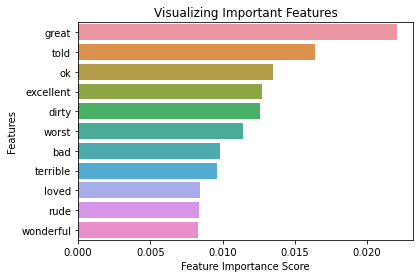

In [64]:
sns.barplot(x=top_feature3, y=top_feature3.index )

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

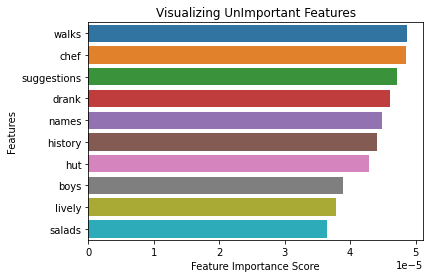

In [65]:
sns.barplot(x=worst_features3, y=worst_features3.index )

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing UnImportant Features")
plt.show()

In [66]:
print(classification_report(y_test, y_test_pred3))

              precision    recall  f1-score   support

           0       0.89      0.52      0.66      1350
           1       0.85      0.98      0.91      3773

    accuracy                           0.86      5123
   macro avg       0.87      0.75      0.78      5123
weighted avg       0.86      0.86      0.84      5123



<function matplotlib.pyplot.show(*args, **kw)>

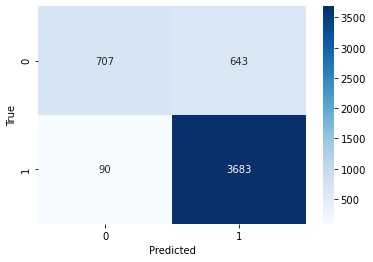

In [67]:
#create the confusion matrix
cf_matrix = confusion_matrix(y_test, y_test_pred3)

#plot the confusion matrix
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show

### Transform the stopwords list and create a new CountVectorizer & repeat the training and evaluation process

In [68]:
my_stopwords = set(ENGLISH_STOP_WORDS)
my_stopwords.remove("not") #  It was ranked as the 2nd most important feature
my_stopwords.add("la")
my_stopwords.add("riu")

In [69]:
#Play with max_df, min_df, max_features
vectorizer4 = CountVectorizer(lowercase=True, stop_words=my_stopwords, max_df=0.9, min_df=100, max_features=20000)